(100, 10)
(90, 10)
(10, 10)
tensor(366896.7500, grad_fn=<MseLossBackward>)
tensor(138605.7500, grad_fn=<MseLossBackward>)
tensor(80849.7266, grad_fn=<MseLossBackward>)
tensor(116697.2969, grad_fn=<MseLossBackward>)
tensor(78060.3359, grad_fn=<MseLossBackward>)
tensor(141687.3438, grad_fn=<MseLossBackward>)
tensor(83107.5469, grad_fn=<MseLossBackward>)
tensor(137530.7500, grad_fn=<MseLossBackward>)
tensor(97880.1875, grad_fn=<MseLossBackward>)
tensor(59907.6016, grad_fn=<MseLossBackward>)
(10,)
(10,)
Accuracy:  0.1


Text(0.5, 0, 'Epochs')

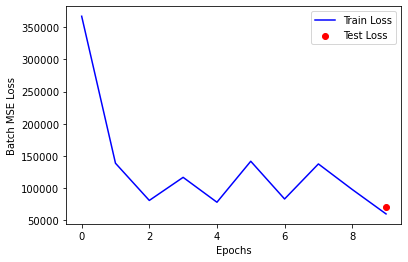

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from math import isclose
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#dataset = pd.read_csv('')

residues = [ 'pep_1','pep_2','pep_3','pep_4','pep_5','pep_6','pep_7','pep_8','pep_9']
outputs = ['optimizer']

#numeric residue conversion
#dataset = dataset.replace(['A','R','N','D','C','Q','E','G','H','I','L',
 #                         'K','M','F','P','S','T','W','Y','V']
  #                        ,['1','2','3','4','5','6','7','8','9','10',
   #                         '11','12','13','14','15','16','17','18','19','20'])

columns = ['pep_1','pep_2','pep_3','pep_4','pep_5','pep_6','pep_7','pep_8','pep_9','optimizer']
dataset = pd.DataFrame(np.random.randint(0,1000,size=(100, 10)), columns=columns)
total, io = dataset.shape
print(dataset.shape)

train = dataset.sample(frac = 0.9)
test = pd.concat([dataset, train], axis=0)
test = test.drop_duplicates(keep=False)

#FUTURE REFERNCE: Consider Embedding residues as n-d arrays

print(train.shape)
print(test.shape)

class Feeder():
    
    def __init__(self,data):
        self.data = torch.FloatTensor(data.values.astype('float'))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        target = self.data[index][-1]
        data_val =self.data[index] [:-1]
        return data_val, target
    
train_data = Feeder(train)
test_data = Feeder(test)



device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}


train_set = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_set = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)


class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = NeuralNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_losses = []
train_counter = []

for epoch in range(10): # 10 full passes over the data
    for data in train_set:  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X)# pass in the batch inputs
        output = output[:, -1]
        loss = F.mse_loss(output, y)  # calc and grab the loss value
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    train_losses.append(loss.item())
    train_counter.append(epoch)
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 
    
test_loss = 0    
test_losses = []
with torch.no_grad(): #Calculate accuracy of each test mutant
    for data in test_set:
        X, y = data
        output = net(X)
        output = torch.squeeze(output,1)
        test_loss = F.mse_loss(output, y)
        test_losses.append(test_loss.item())
        i=0
        correct = 0
        total = 0
        output = output.numpy()
        y = y.numpy()
        print(output.shape)
        print(y.shape)
        for pred, act in list(zip(output, y)):
            #print(output, y)
            if abs((pred - act)/act) <= 0.10:
                correct += 1
            total += 1
        print("Accuracy: ", round(correct/total, 3))

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(epoch, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'])
plt.ylabel('Batch MSE Loss')
plt.xlabel('Epochs')